# Streamlining your machine learning workflows with Scikit-Learn pipelines

This notebook introduces Scikit-Learn pipelines, which can help you organize and streamline your data processing and model training, as well as make your code cleaner and easier to manage.

We will cover what pipelines are, why to use them in your machine learning code, review the components of `sklearn`'s [Pipeline](https://scikit-learn.org/1.5/modules/generated/sklearn.pipeline.Pipeline.html), and go through an end-to-end example using a classification task, i.e. predicting a categorical outcome.

## Section 0. Importing libraries and datasets

In [6]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

We will be using a few datasets available through scikit-learn as examples in this workshop: MNIST, Wine, and Iris. All three of these sets are commonly used to demonstrate classification methods. Don't worry if the code used in this section is unfamiliar to you; it's just there to show you what the data look like.

First, the classic MNIST dataset contains 28x28 pixel images of handwritten numbers.

In [17]:
# Load the MNIST dataset:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist_X, mnist_y = mnist.data, mnist.target.astype(int)  # Features and labels

**If the previous cell does not run successfully**, then you can manually upload the `mnist.npz` data file available on GitHub.

**If you are using Google Colab**: un-comment out and run the following cell. Use the "Choose Files" button to upload the data file from your computer, then un-comment out and run the cell containing the `np.load` command.

**If you are on a Jupyter host**: make sure the data file is saved to the same location as this notebook, then un-comment out and run only the cell containing the `np.load` command.

In [20]:
# from google.colab import files
# mnist = files.upload()

In [21]:
# data = np.load("mnist.npz")
# mnist_X, mnist_y = data['mnist_X'], data['mnist_y']

Now that we have the MNIST dataset loaded up, we can visualize some of the samples.

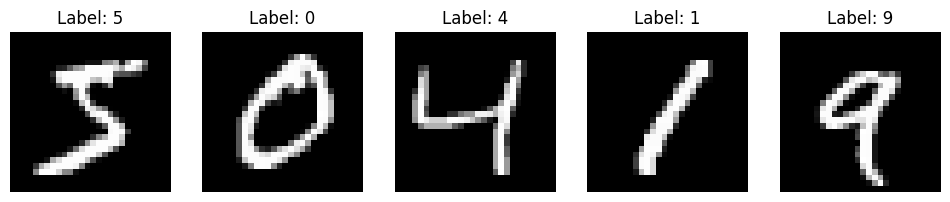

In [22]:
fig, axes = plt.subplots(1, 5, figsize=(12, 3))
for i, ax in enumerate(axes):
    ax.imshow(mnist_X[i].reshape(28, 28), cmap='gray')
    ax.axis('off')
    ax.set_title(f"Label: {mnist_y[i]}")
plt.show()

The 'Wine' dataset contains measurements of 178 wine samples for 13 chemical features including alcohol content, malic acid, total phenols, along with each sample's wine class (Class 0, 1, or 2).

Shape of Wine dataset features: (178, 13)
Shape of Wine dataset target values: (178,)


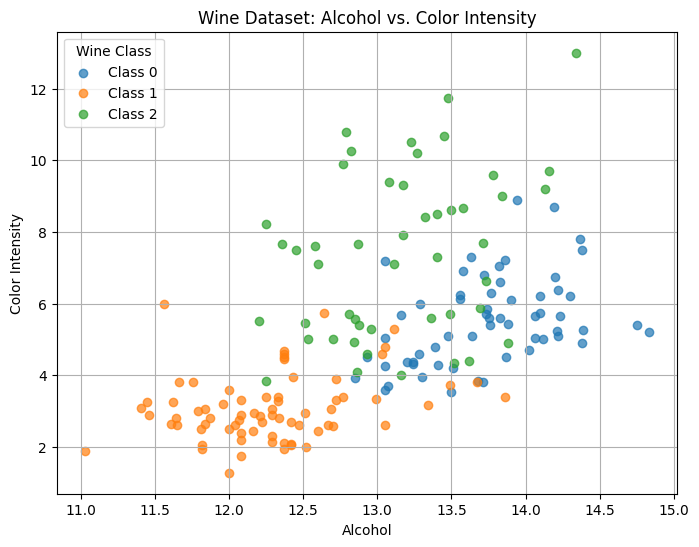

In [14]:
from sklearn.datasets import load_wine

# Load the Wine dataset
wine = load_wine()
wine_X, wine_y = wine.data, wine.target

print(f"Shape of Wine dataset features: {wine_X.shape}")
print(f"Shape of Wine dataset target values: {wine_y.shape}")

plt.figure(figsize=(8, 6))
for target_class in set(wine_y):
    plt.scatter(
        wine_X[wine_y == target_class, wine.feature_names.index('alcohol')],
        wine_X[wine_y == target_class, wine.feature_names.index('color_intensity')],
        label=f'Class {target_class}',
        alpha=0.7
    )
plt.title('Wine Dataset: Alcohol vs. Color Intensity')
plt.xlabel('Alcohol')
plt.ylabel('Color Intensity')
plt.legend(title='Wine Class')
plt.grid(True)
plt.show()

In [15]:
# Convert dataset to a DataFrame for better readability
wine_df = pd.DataFrame(wine_X, columns=wine.feature_names)

# Set wine class
wine_df['target'] = wine_y
display(wine_df)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0,2
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0,2
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0,2
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0,2


The 'Iris' dataset contains measurements of 150 iris flowers from three different species (Setosa, Versicolor, Virginica). Each flower sample in the dataset has 4 features: sepal length, sepal width, petal length, and petal width.

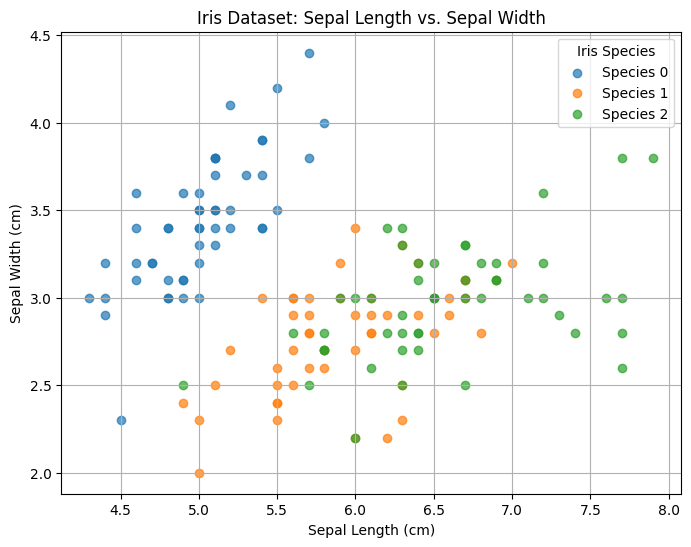

In [6]:
from sklearn.datasets import load_iris

# Load the Iris dataset
iris = load_iris()
iris_X, iris_y = iris.data, iris.target

plt.figure(figsize=(8, 6))
for target_class in set(iris_y):
    plt.scatter(
        iris_X[iris_y == target_class, iris.feature_names.index('sepal length (cm)')],
        iris_X[iris_y == target_class, iris.feature_names.index('sepal width (cm)')],
        label=f'Species {target_class}',
        alpha=0.7
    )
plt.title('Iris Dataset: Sepal Length vs. Sepal Width')
plt.xlabel('Sepal Length (cm)')
plt.ylabel('Sepal Width (cm)')
plt.legend(title='Iris Species')
plt.grid(True)
plt.show()

## Section 1. Machine Learning workflows

ML workflows often involve multiple steps: preprocessing data, feature engineering (i.e. selecting and transforming predictors), training models, and evaluating performance. Managing these workflows effectively can be tedious, especially as the complexity of datasets and models increases.

Below is an example of a standard ML workflow for analyzing the MNIST dataset.

First, we split the data to create separate training and testing datasets for training the model and evaluating model performance. We slice the dataset to only inlcude the first 100,000 samples from the MNIST dataset to reduce training time. The argument `test_size=0.2` specifies an 80/20 training/testing split.  

In [7]:
X_train, X_test, y_train, y_test = train_test_split(mnist_X[:100000],
                                                    mnist_y[:100000],
                                                    test_size=0.2,
                                                    random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(56000, 784)
(56000,)
(14000, 784)
(14000,)


### ML workflow step 1: Preprocessing the data

Image data generally comes in a matrix of numbers, with each number signifying the brightness of one pixel in the image. When working with image data, the values can vary widely. Pixel values usually range from 0 to 255. To help machine learning models learn more effectively, we **standardize** these values using `StandardScaler` so that they have a mean of 0 and a standard deviation of 1.

In [8]:
scaler = StandardScaler()                      # Initialize scaler object
scaler.fit(X_train)                            # Fit scaler to training data
X_train_scaled = scaler.transform(X_train)     # Scale training data
X_test_scaled = scaler.transform(X_test)       # Scale test data using the same scaler

Exercise: What is the mean and standard deviation of the unscaled vs scaled data?

### ML workflow step 2: Reducing dimensionality

In machine learning, especially with image data or datasets with many features, we often deal with high-dimensional data. For example, a 28x28 pixel MNIST image has 784 features (one for each pixel). Processing all these features can slow down training, and increase the risk of overfitting noise. Using methods like Principal Component Analysis (PCA) can reduce the number of features while keeping the most important information. The argument `n_components=50` specifies that we want to reduce our dataset to 50 dimensions. The function `PCA.transform` converts data from the original 784 dimensions into the reduced 50 dimensions established by the PCA.

In [9]:
pca = PCA(n_components=50)                       # Initialize PCA object
pca.fit(X_train_scaled)                          # Fit PCA to our scaled data
X_train_reduced = pca.transform(X_train_scaled)  # Reduce dimensionality of training data
X_test_reduced = pca.transform(X_test_scaled)    # Reduce dimensionality of testing data

Exercise: What are the dimensions of the data in the original vs reduced dimensions? Are these what you expected?

### ML workflow step 3: Train a logistic regression model for classification

Here, the arguments `max_iter` and `solver` represent the maximum number of iterations in the training, and the algorithm used to optimize the model, respectively.

In [10]:
model = LogisticRegression(max_iter=1000, solver='lbfgs')
model.fit(X_train_reduced, y_train)

LogisticRegression(max_iter=1000)

### ML workflow step 4: Make predictions
We can now use our model to make predictions based on the features of data that were not used in training (i.e., the testing set)

In [11]:
y_pred = model.predict(X_test_reduced)

### ML workflow step 5: Evaluate model
The function `classification_report` provides quantitative details on the accuracy of the model predictions, compared to the actual classes of the testing dataset.

The metrics included are:
1. Precision: percent of accurate predictions.
2. Recall (Sensitivity): ability to identify all relevant cases.
3. F1-Score: balance of precision and recall.
4. Support: number of occurrances of each class in the set (to contextualize other metrics).

In [ ]:
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.96      0.96      1343
           1       0.94      0.97      0.96      1600
           2       0.90      0.89      0.89      1380
           3       0.87      0.87      0.87      1433
           4       0.91      0.92      0.91      1295
           5       0.86      0.85      0.85      1273
           6       0.94      0.95      0.95      1396
           7       0.92      0.93      0.92      1503
           8       0.87      0.83      0.85      1357
           9       0.88      0.88      0.88      1420

    accuracy                           0.91     14000
   macro avg       0.90      0.90      0.90     14000
weighted avg       0.91      0.91      0.91     14000



### Exercise: write a workflow for either the Wine or Iris dataset, or a dataset of your own.

## Section 2. Benefits of modularizing workflows with pipelines

Machine learning workflows often involve multiple sequential steps, such as data preprocessing, dimensionality reduction, model training, and evaluation. Managing these steps individually can become cumbersome and error-prone, especially when conducting a series of similar analyses or experimenting with different methods.

Pipelines in Scikit-Learn provide a solution by modularizing these workflows. (**Modularizing** means breaking a process down into smaller, self-contained steps or components, each responsible for a specific task, which can then be combined into a more complex process.) Instead of writing separate code blocks for each step, pipelines allow you to chain these steps into a single, cohesive object. This modular approach ensures that:

* Steps are consolidated into a single object to reduce repetitive, generic code and to eliminate redundancy.
* Steps are all executed in the correct order (e.g., scaling before PCA).
* Preprocessing is consistently applied to both training and test data.
* Code readability and maintainability are significantly improved.
* Reproducibility is enhanced, as the entire workflow can be saved, shared, and reloaded.
* Components can be swapped out easily to try other dimensionality reduction methods or predictive models without altering the rest of the pipeline.

## Section 3. Understanding the Components of a Scikit-learn `Pipeline`

A Scikit-Learn pipeline is composed of transformers and an estimator, combined into a cohesive workflow.

We will take a look at some examples of transformers and estimators as applied to two scikit-learn datasets commonly used for classification: 'Wine' and 'Iris'.

***Transformers*** are objects that preprocess data (e.g., scaling, encoding, or dimensionality reduction).

In [ ]:
# Transformer: StandardScaler to standardize data
scaler = StandardScaler()
scaler.fit(wine_X)  # Calculate scaling so that mean=0 and st dev=1
wine_X_scaled = scaler.transform(wine_X)  # Apply scaling to data

# Transformer: PCA for dimensionality reduction
pca = PCA(n_components=5) # Reduce features from 13 to 5
pca.fit(wine_X_scaled)  # Learn principal components
wine_X_reduced = pca.transform(wine_X_scaled)  # Reduce dimensionality

***Estimators*** are objects that train and predict (e.g., Logistic Regression, SVM, Random Forest). The examples given here can all be used as classifiers. In the code block below I show how each of these estimators are instantiated with relevant tunable hyperparameters. Each is then applied to the training data in the same way.

It's ok if you're not familiar with these particular types of models; this is just to show that these estimators which all perform the same task are treated the same in scikit-learn syntax.

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Split iris data into testing and training
X_train, X_test, y_train, y_test = train_test_split(iris_X, iris_y, random_state=42)

# Estimator: Logistic Regression
log_reg = LogisticRegression(max_iter=500)
log_reg.fit(X_train, y_train)
print(f"Logistic Regression Accuracy: {log_reg.score(X_test, y_test):.2f}")

# Estimator: Support Vector Machine (SVM)
svm = SVC(kernel='rbf', C=1.0, gamma='scale')  # Radial Basis Function (RBF) kernel
svm.fit(X_train, y_train)
print(f"SVM Accuracy: {svm.score(X_test, y_test):.2f}")

# Estimator: Random Forest Classifier
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest.fit(X_train, y_train)
print(f"Random Forest Accuracy: {random_forest.score(X_test, y_test):.2f}")

# Estimator: k-Nearest Neighbors (k-NN)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
print(f"k-NN Accuracy: {knn.score(X_test, y_test):.2f}")

Logistic Regression Accuracy: 1.00
SVM Accuracy: 1.00
Random Forest Accuracy: 1.00
k-NN Accuracy: 1.00


### Question: what are some other examples of transformers and estimators that you can think of?

Please type any examples you can think of in the chat.

## Section 4. Constructing a Scikit-Learn pipeline

To create a `Pipeline` in scikit-learn, provide a list of steps where each step is a tuple consisting of:
*   A name (a short label for the step)
*   A transformer or estimator (the function that processes the data)

The steps should follow the order of
your workflow, with the final step being the model (estimator) that makes predictions.







In [ ]:
# Instantiate sklearn Pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2)),
    ('classifier', KNeighborsClassifier(n_neighbors=5))
])

Once you have the pipeline instantiated, you can fit it to a dataset using `fit` and make predictions based on input data using `predict`:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(mnist_X[:100000],
                                                    mnist_y[:100000],
                                                    test_size=0.2,
                                                    random_state=42)

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Predict and evaluate on the test data
y_pred = pipeline.predict(X_test)

Let's take a look at some of the predictions! Don't worry if the code used to make these visualizations is unfamiliar.

In [ ]:
# Visualize some predictions
fig, axes = plt.subplots(1, 5, figsize=(12, 3))
for i, ax in enumerate(axes):
    # Select a random image from the test set
    idx = np.random.randint(0, len(X_test))

    # Reshape the flattened image back to 28x28
    image = X_test[idx].reshape(28, 28)

    # Plot the image
    ax.imshow(image, cmap='gray')
    ax.axis('off')

    # Show the predicted and true label
    ax.set_title(f"Pred: {y_pred[idx]}\nTrue: {y_test[idx]}")

plt.tight_layout()
plt.show()

We can also plot a **confusion matrix** to compare the true labels with the predicted labels to count correct and incorrect predictions, as well as which classes are more or less likely to be correctly predicted. Again, don't worry about the code used here to make the plot.

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix for MNIST Predictions")
plt.show()


## Section 5. Putting it all Together

Use a pipeline to create, train, and evaluate a classifier for the Iris or Wine dataset, or a dataset of your own. You can use the same steps as in the first workflow introduced in Part 1, or any other combination of transformers and estimators given in Part 3.

## Bonus: Create Your Own Pipeline!

Try using a sklearn `Pipeline` to streamline an existing ML workflow from your own research!

You can also try using a non-scikit-learn function in a pipeline, provided it implements the following methods:
1. `fit(X,y)`: To train the model
2. `predict(X)`: To make predictions
3. `score(X,y)` for evaluation
4. `transform(X)` for transformers

Two examples of functions that meet these criteria are `XGBClassifier` from `XGBoost` and `LGBMClassifier` from `LightGBM`. You can also create your own custom functions that have the requisite methods.